## Time Series Forecasting with Prophet

### Introduction 

Time series forecasting is used in multiple business domains, such as pricing, capacity planning, inventory management, etc. Forecasting with techniques such as ARIMA requires the user to correctly determine and validate the model parameters $(p,d,q)$. This is a multistep process that requires the user to interpret the Autocorrelation Function (ACF) and Partial Autocorrelation (PACF) plots correctly. Using the wrong model can easily lead to erroneous results.  

[Prophet](https://facebook.github.io/prophet/docs/) is an open source time series forecasting library made available by Facebook's Core Data Science team. It is available both in Python and R, and it's syntax follow's [Scikit-learn's](http://scikit-learn.org/) `train` and `predict` model. 

Prophet is built for [business cases](https://research.fb.com/prophet-forecasting-at-scale) typically encounted at Facebook, but which are also encountered in other businesses:

1. Hourly, Daily or Weekly data with sufficient historical data
2. Multiple Seasonality patterns related to human behaviour (day of week, seasons)
3. Important holidays that are irregularly spaced (Thanksgiving, Chinese New Year, etc.) 
4. Reasonable amount of missing data
5. Historical trend changes 
6. Non linear growth trends with saturation (capacity limit, etc.) 

The goal of Prophet is to product high quality forecasts for decision making out of the box without requiring the user to have expert time series forecasting knowledge. The user can intuitively intervene during the model building process by introducing known parameters such as trend changepoints due to product introduction or trend saturation values due to capacity. 


### Stan 

Prophet uses [Stan](http://mc-stan.org/) as its optimization engine to fit its model and calculate uncertainty intervals. Stan is installed along with the R or Python libraries when Prophet is installed. Stan performs Maximum a Priori (MAP) optimization by default but if sampling can be requested. 

### Data 

According to Facebook, Prophet is able to give accurate forecasting results with it's **default settings, little or no tuning required**. Let's test out Prophet using two different datasets:

1. [Singapore Changi Airport Passenger arrivals](https://data.gov.sg/dataset/air-passenger-arrivals-total-by-region-and-selected-country-of-embarkation)
2. [Maritime Tanker Arrival Data](https://data.gov.sg/dataset/tanker-arrivals-75-gt-monthly) in Singapore 

We'll use the **python** library as there not many time series forecasting libraries in this language whereas R has [popular packages](https://cran.r-project.org/web/views/TimeSeries.html) such as `forecast`, `tseries`, etc. 

We'll load the tanker data into the dataframe `tanker` and the flight passenger data into the dataframe `air`.

In [159]:
import pandas as pd
from fbprophet import Prophet

air=pd.read_csv('D:/total-air-passenger-arrivals-by-country.csv')

# Filter Data for Passengers from China and drop na
air=air[air.level_3=='China']
air=air.drop(['level_1','level_2','level_3'],axis=1)
air=air[(air.value!='na') & (air.value!='-')]


In [185]:
tanker=pd.read_csv('D:/tanker-arrivals-breakdown-monthly.csv')

# Filter Data for Oil Tankers only
tanker=tanker[tanker.category == 'Oil Tankers']
tanker=tanker.drop(['category','gross_tonnage'],axis=1)

Prophet requires the input dataframe's columns to be named `ds` and `y`. 

In [188]:
tanker = tanker.rename(columns = {'month': 'ds',
                                'number_of_tankers': 'y'})
air=air.rename(columns={'month':'ds','value':'y'})


### Parameters  
According to Facebook's [article](https://peerj.com/preprints/3190.pdf), Prophet uses an additive model:  

$$y(t) = g(t) + s(t) + h(t) +\epsilon_t$$

where $g(t)$ represents the trend, $s(t)$ the periodic component, $h(t)$ holiday related events and $\epsilon_t$ the error. Our data is monthly so we are unanble to model using holidays. 

Let us model the air passenger arrival data first. The syntax is similar to `scikit-learn`:

In [163]:
model_air=Prophet()
model_air.fit(air)
future_air=model_air.make_future_dataframe(periods=10*12)
forecast_air=model_air.predict(future_air)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet automatically detected monthly data and disabled weekly and daily seasonality. We can plot the forecast by Prophet

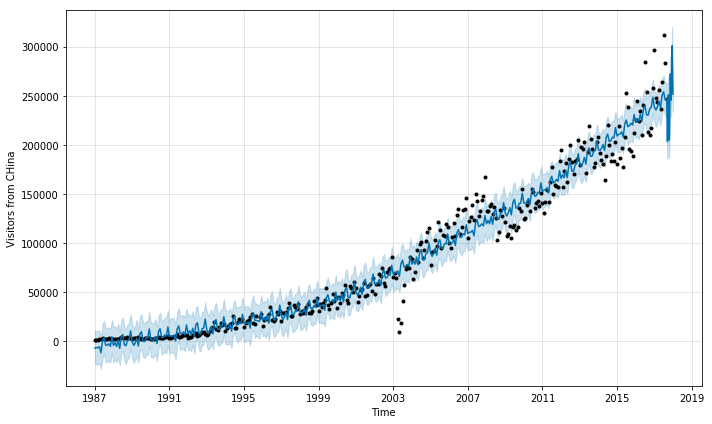

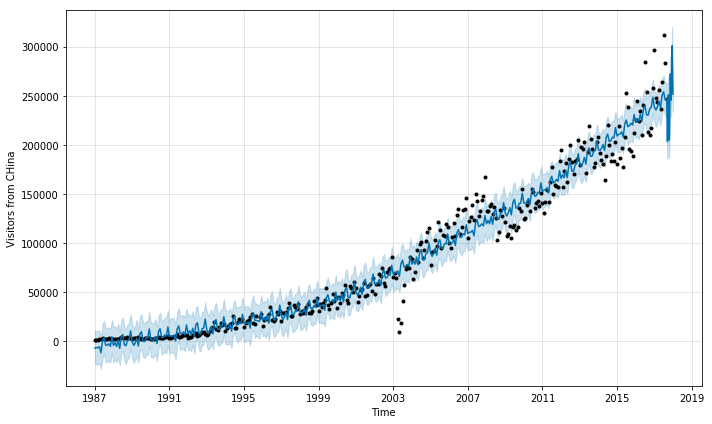

In [164]:
model_air.plot(forecast_air,xlabel='Time',
                             ylabel='Visitors from CHina')

### Multiplicative Seasonality
We see that an additive model is not suitable; the predicted fluctuation due to seasonality is constant throughout the years. In reality we observe that the fluctuation is increasing. We can ask `Prophet` use multiplicative model instead. 

In [167]:
model_air=Prophet(seasonality_mode='multiplicative')
model_air.fit(air)
future_air=model_air.make_future_dataframe(periods=10*12)
forecast_air=model_air.predict(future_air)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


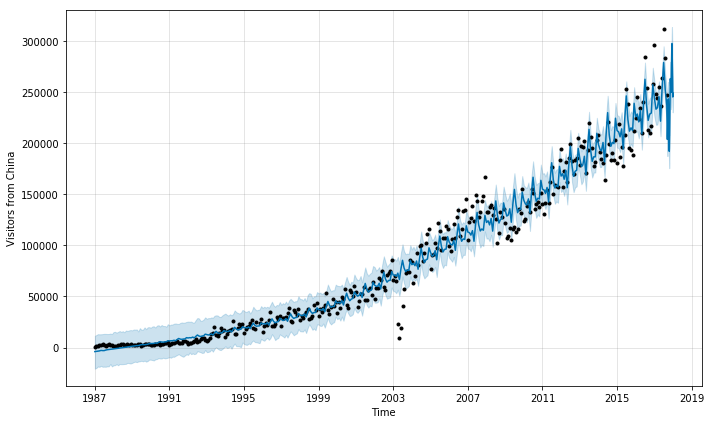

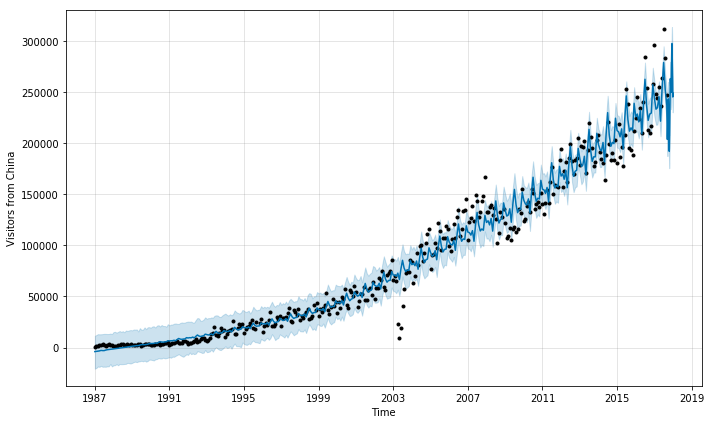

In [172]:
model_air.plot(forecast_air,xlabel='Time',
                             ylabel='Visitors from China')

The seasonality effect increases over time with a multiplicative model. 

### Trend Change Points
The trend in a real time series can change abruptly. Prophet attempts to detect these changes automatically using a Laplacian or double exponential prior. By default, the change points are only fitted for the 1st 80% of the time series. In the passenger arrival data, note that there is a sharp dip in 2003 due to the [SARS](https://en.wikipedia.org/wiki/Severe_acute_respiratory_syndrome) outbreak in Singapore. These outliers should ideally be removed. Let's display the change points detected by Prophet:

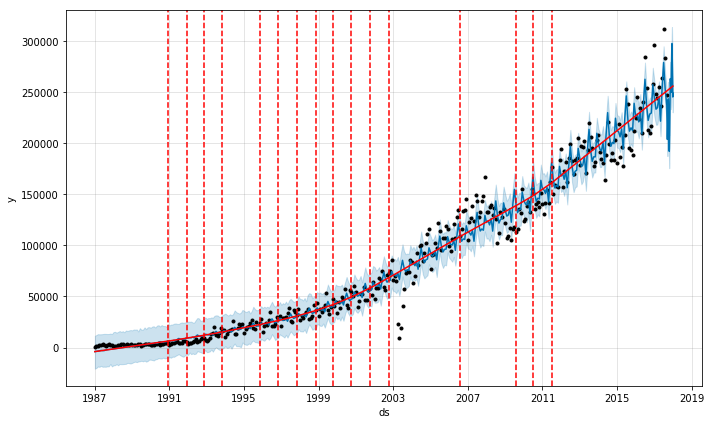

In [174]:
from fbprophet.plot import add_changepoints_to_plot
fig_air=model_air.plot(forecast_air)
a=add_changepoints_to_plot(fig_air.gca(),model_air,forecast_air)

Visually it appears that the general trend is correct but it is being underfit. For example the decline during the 2008-2009 financial crisis is not detected. To adjust the trend change, we can use the parameter `changepoint_prior_scale` which is set to 0.05 by default. Increasing its value would make the trend more flexible and reduce underfitting, at the risk of overfitting. Let us set it to 0.5 as suggested by the Prophet [Documentation Guide](https://facebook.github.io/prophet/docs/trend_changepoints.html). If we want to generate uncertainty intervals for the trend and seasonality components, we need to perform full Bayesian sampling, which can be done by using the `mcmc_samples` parameter in Prophet. 

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


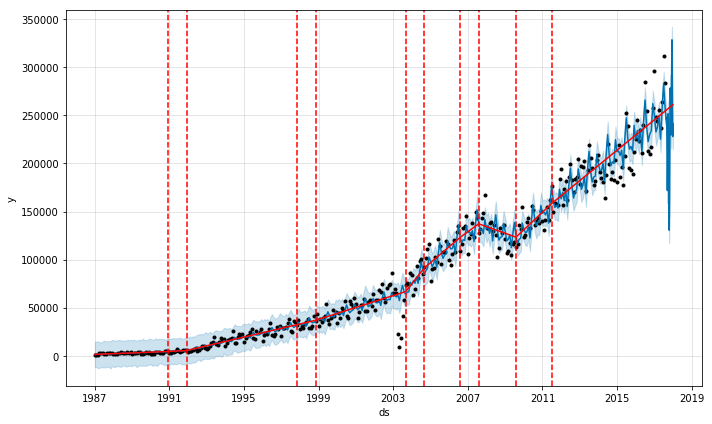

In [182]:
model_air = Prophet(changepoint_prior_scale=0.5,
                    seasonality_mode='multiplicative')
forecast_air = model_air.fit(air).predict(future_air)
fig_air = model_air.plot(forecast_air)
a=add_changepoints_to_plot(fig_air.gca(),model_air,forecast_air)

### Plot Model Components
We get a better fit of the trend when increasing `changepoint_prior_scale`. The decline during the financial crisis can be detected. The user can also manually enter  Using the `plot_components` function we can display the components of the model:

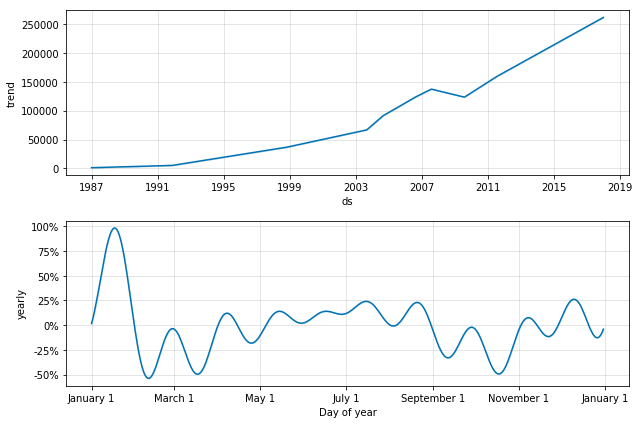

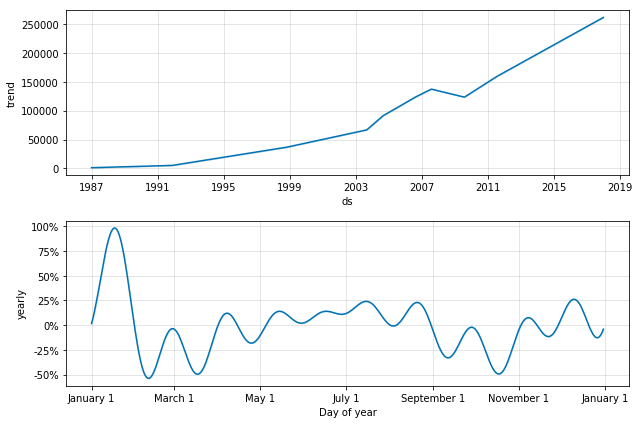

In [183]:
model_air.plot_components(forecast_air)

### Tanker Data - Additional Regressor

In [211]:
model_tanker=Prophet(changepoint_prior_scale=0.25)
model_tanker.fit(tanker)


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [212]:
future_tanker=model_tanker.make_future_dataframe(periods=2*12)

In [213]:
forecast_tanker=model_tanker.predict(future_tanker)


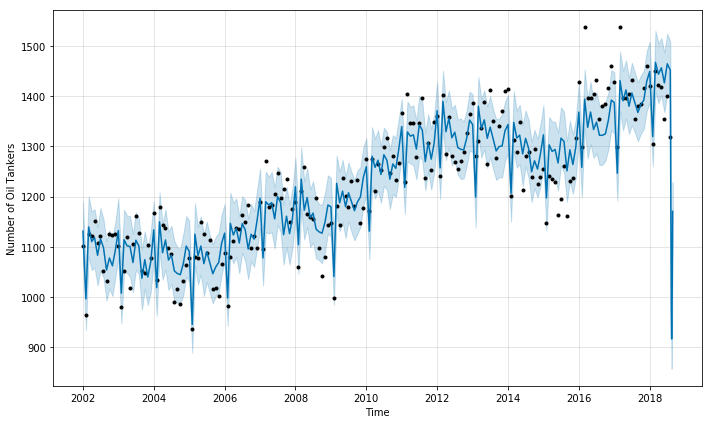

In [214]:
out_tanker=model_tanker.plot(forecast_tanker, xlabel='Time',
                             ylabel='Number of Oil Tankers')

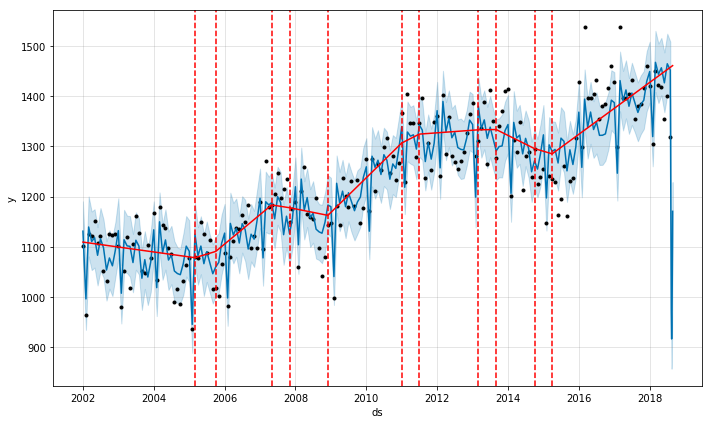

In [215]:
from fbprophet.plot import add_changepoints_to_plot
fig_tanker=model_tanker.plot(forecast_tanker)
a=add_changepoints_to_plot(fig_tanker.gca(),model_tanker,forecast_tanker)

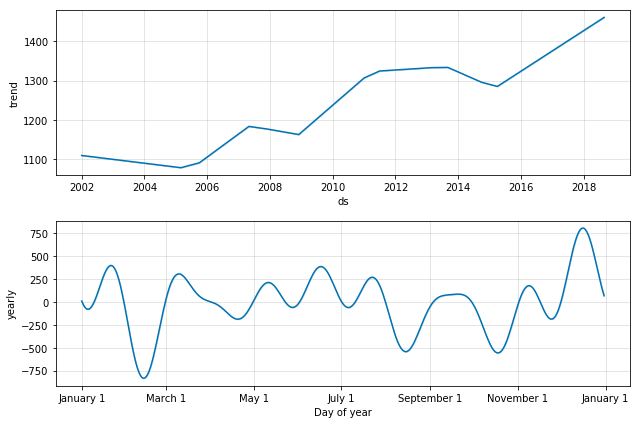

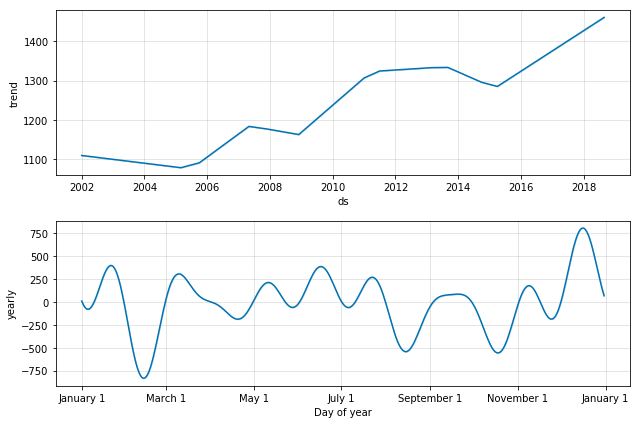

In [216]:
model_tanker.plot_components(forecast_tanker)
